# **Large Language Models**

Large language models gathered popularity among a wider audience after the release of ChatGPT in November 30, 2022. But within machine learning community, language modeling is a known task for decades but in the last 5-10 years, there is a significant progress in this field. Modern hardwares, enormous availability of digital data in the internet era and the advancements in the field of machine learning algorithms in general lead to this progress, and eventually 

Language modeling is a common method of pretraining on unlabeled text (self supervised learning). Most of the language models learned by iteratively predicting next word in a sequence auto regressively. Large language models are gigantic machine learning architectures (stacking neural network layers depthwise to scale it to billions of parameters) are semi-supervised models trained on huge ammounts of data. The exisiting large language models are heavy in size and requires months to train. Though the LLMs are trained, they may not perform well in specific tasks. In this notebook, we try to demonstrate one of the many possible ways to improve the performance of an already trained LLM for a specific task/dataset.

### **Pretrain a large language model**

If you have enough data, required hardwares and expertise in training large neural network architectures, you can train your own Large language models. One can either opt for an existing architecture, or customize one. This is a very expesive process that requires a lot of resources. Deeper understanding of LLM model architecture is beyond the scope of this notebook and here we try to focus on fine-tuning a trained LLM using a specific Parameter-efficient fine-tuning (PEFT) technique called "QLoRA."

# **How to use Large language models for Specific Tasks ?**


### **1) Prompting**

This is the most simple way to use large language models. Prompting relies on providing explicit instructions or queries to the model, and the model generates responses based on those prompts.

You can read more about it here - https://huggingface.co/docs/transformers/main/tasks/prompting


### **2) Retrieval-augmented generation**

Ref : https://arxiv.org/abs/2005.11401

Retrieval-augmented generation (RAG) is a method for improving the quality of LLM-generated responses by grounding the model on external sources of knowledge to supplement the LLM’s internal representation of information. 

### **3) Supervised Fine-tuning**

Finetuning large language models is a highly effective way to improve their performance, especially in specific downstream tasks. The parameters of the LLMs won't change when we perform prompting or RAG. This simply means we don't calculate gradients of loss with respect to parameters and do not perform backpropagation. But in finetuning, all or atleast some of the model parameters are updated, making finetuning more expensive than performing prompting or RAG. Finetuning very large models is prohibitively expensive; regular 16-bit finetuning of a LLaMA 65B parameter model requires more than 780 GB of GPU memory. For fine-tuning such large neural networks, Parameter-efficient fine-tuning (PEFT) is a feasible method, where we will only update a small set of parameters. There exists quantization techniques for reducing memory footprints of LLMs that works well during inference. QLoRA is a PEFTtechnique approach for quantized large language models. In this notebook, we try to fine-tune a popular large language model called Mistral AI, using QLoRA finetuning method.

# **QLoRA**

Reference - https://arxiv.org/abs/2305.14314


QLoRA is an efficient finetuning approach for Large language models, especially when you have limited resources. QLoRA backpropagates gradients through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters~(LoRA). QLoRA cleverly combines two methods that is widely used in neural network compression, Low Rank Adaptation and Quantization. 

### **Low Rank Adaptation (LoRA)**

Reference - https://arxiv.org/pdf/2106.09685.pdf

LoRA, which freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture, greatly reducing the number of trainable parameters for downstream task.

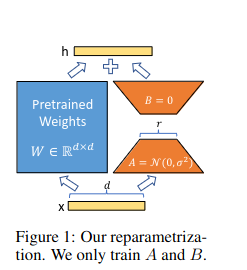

Figure 1 illustrates how LoRA works for a parameter matrix $W$ of $ d * d $. There exist works that shows that the learned over-parametrized models reside on a low intrinsic dimension.The authors of the LoRA hypothesize that the change in weights during model adaptation also has a low “intrinsic rank”. LoRA allows us to train some dense layers in a neural network indirectly by optimizing rank decomposition matrices of the dense layers’ change during adaptation instead, while keeping the pre-trained weights froze.

### **Quantization**

QLORA introduces a number of innovations to save memory without sacrificing performance: 
(a) 4-bit NormalFloat (NF4), a new data type that is information theoretically optimal for normally distributed weights <br>
(b) Double Quantization to reduce the average memory footprint by quantizing the quantization constants <br>
(c) Paged Optimizers to manage memory spike <br>

There exists quantization techniques for reducing memory footprint of LLMs, and with QLORA, it is possible to quantize a pretrained model to 4-bit.

# **Model**

In this notebook, we use an opensource model Mistral 7B as the pretrained model for finetuning. How it is trained is beyond the scope of this notebook, but before jumping into modeling, I request everyone to go through the model documentation to get an idea about the model.

Ref : https://mistral.ai/news/announcing-mistral-7b/

# **Data**

In this notebook, we are finetuning the model on the dataset ViGGO – a smaller but more comprehensive dataset in the video game domain. The dataset provides almost 7K pairs of structured meaning representations (MRs) and crowdsourced reference utterances about more than 100 video games.

Reference - https://arxiv.org/pdf/1910.12129v1.pdf

# **Code**

Ref: https://www.e2enetworks.com/blog/a-step-by-step-guide-to-fine-tuning-the-mistral-7b-llm

### Installing dependencies

In [1]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install peft

  Obtaining dependency information for peft from https://files.pythonhosted.org/packages/82/cc/bf022d6bc3996a5939c3ee39bde2b0e1f8bf6cea6ef9c9cdaf1639586237/peft-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.3 MB/s eta 0:00:00


### Importing libraries

In [2]:
import torch
import transformers
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoTokenizer,BitsAndBytesConfig
from datasets import load_dataset
from peft import prepare_model_for_kbit_training,LoraConfig,PeftModel,get_peft_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading the pre-trained model

In [3]:
model_path = "/kaggle/input/mistral/pytorch/7b-v0.1-hf/1"
device = "cuda" # the device to load the model onto

# Quantization configuration

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Loading the model and tokenizer

model = AutoModelForCausalLM.from_pretrained(model_path,quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    model_max_length=512,
    padding_side="left",
    add_eos_token=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load dataset

In [4]:
train_dataset = load_dataset('gem/viggo', split='train')
eval_dataset = load_dataset('gem/viggo', split='validation')
test_dataset = load_dataset('gem/viggo', split='test')

Extracting data files:   0%|          | 0/8 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5103 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/714 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1083 [00:00<?, ? examples/s]

Generating challenge_train_1_percent split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating challenge_train_2_percent split:   0%|          | 0/103 [00:00<?, ? examples/s]

Generating challenge_train_5_percent split:   0%|          | 0/256 [00:00<?, ? examples/s]

Generating challenge_train_10_percent split:   0%|          | 0/510 [00:00<?, ? examples/s]

Generating challenge_train_20_percent split:   0%|          | 0/1021 [00:00<?, ? examples/s]

Dataset viggo downloaded and prepared to /root/.cache/huggingface/datasets/gem___viggo/default/1.0.0/529ffe217015a8d6699ed7c6a70aa3fc0320b2e697bb816cef049f2e2ffc0298. Subsequent calls will reuse this data.


In [5]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [6]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']


### Target sentence:
{data_point["target"]}


### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

  0%|          | 0/5103 [00:00<?, ?ex/s]

  0%|          | 0/714 [00:00<?, ?ex/s]

In [8]:
print("Target Sentence: " + test_dataset[1]['target'])
print("Meaning Representation: " + test_dataset[1]['meaning_representation'] + "\n")

Target Sentence: Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?
Meaning Representation: verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])



### Evaluate a prompt

In [9]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']


### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?


### Meaning representation:
"""

In [10]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']


### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?


### Meaning representation:
для_all_games_which_don't_have_multiplayer_is_your_opinion_true_for_playstation's_little_big_adventure


### Meaning representa

## Fine-tuning the model

In [11]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [12]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
print_trainable_parameters(model)
# Apply the accelerator. You can comment this out to remove the accelerator.
#model = accelerator.prepare_model(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


In [13]:
project = "viggo-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name


tokenizer.pad_token = tokenizer.eos_token


trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=300,         # Add a more higher value for better performance
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=50,
        #bf16=True,                #bf16 doesnot support v100,p100. For TPU, set this to true
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to='none',           # set to 'wandb' for weights & baises logging
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,0.755000,0.275678
100,0.251300,0.228417
150,0.220000,0.208071
200,0.200700,0.196357
250,0.193300,0.188917
300,0.185700,0.186532


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

TrainOutput(global_step=300, training_loss=0.3010076936086019, metrics={'train_runtime': 14609.659, 'train_samples_per_second': 0.164, 'train_steps_per_second': 0.021, 'total_flos': 5.25822226071552e+16, 'train_loss': 0.3010076936086019, 'epoch': 0.47})

## Load the trained model

In [14]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_path,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                          padding_side="left",
                                          add_eos_token=True,
                                          trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load the finetuned model and evaluate the prompt

In [15]:
ft_model = PeftModel.from_pretrained(base_model, "mistral-viggo-finetune/checkpoint-300")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True,repetition_penalty=2))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']


### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?


### Meaning representation:
 Given that you didn't like Little Big Adventure, do you feel the same way about other games that don't have multiplayer?


###